In [1]:
# import packages
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits

from scipy.optimize import curve_fit

In [2]:
# read files in and populate arrays
temps = ['-25', '-20', '-15', '-10', '-5', '0', '5', '10', '15', 'room'] # 20 degrees skipped due to CCD cooling constraints

dark_frames = []
for i in range(len(temps)):
    filename = 'dark_' + temps[i] + '.fit'
    data = fits.open(filename)[0].data
    data = np.array(data, dtype=np.float64)
    dark_frames.append(data)

bias_frames = []
for i in range(len(temps)):
    filename = 'bias_' + temps[i] + '.fit'
    data = fits.open(filename)[0].data
    data = np.array(data, dtype=np.float64)
    bias_frames.append(data)

In [3]:
# perform frame-wise subtraction
dark_sub_bias = []
for i in range(len(temps)):
    dark_sub_bias.append(dark_frames[i] - bias_frames[i])

In [4]:
# output ADU statistics of bias-subtracted dark frames
lower = 1024
upper = 3072

def accumulate_pixels(pixels):
    arr = []
    for i in range(lower, upper):
        for j in range(lower, upper):
            arr.append(pixels[i][j])
    return arr

means = []
meds = []
mins = []
maxes = []
stds = []
for i in range(len(temps)):
    frame_arr = accumulate_pixels(dark_sub_bias[i])
    means.append(np.mean(frame_arr))
    meds.append(np.median(frame_arr))
    mins.append(np.min(frame_arr))
    maxes.append(np.max(frame_arr))
    stds.append(np.std(frame_arr))
    
    print("Temperature: " + temps[i])
    print("Mean: " + str(np.mean(frame_arr)))
    print("Median: " + str(np.median(frame_arr)))
    print("Min: " + str(np.min(frame_arr)))
    print("Max: " + str(np.max(frame_arr)))
    print("Standard Deviation: " + str(np.std(frame_arr)))
    print()

Temperature: -25
Mean: -0.22899794578552246
Median: -1.0
Min: -490.0
Max: 45263.0
Standard Deviation: 71.37156056578253

Temperature: -20
Mean: 0.5049097537994385
Median: 0.0
Min: -126.0
Max: 45381.0
Standard Deviation: 81.90607513632254

Temperature: -15
Mean: 1.3552346229553223
Median: 1.0
Min: -1088.0
Max: 45416.0
Standard Deviation: 99.59472058724936

Temperature: -10
Mean: 2.395724296569824
Median: 1.0
Min: -72.0
Max: 45552.0
Standard Deviation: 115.6527765361734

Temperature: -5
Mean: 4.425814151763916
Median: 3.0
Min: -203.0
Max: 45537.0
Standard Deviation: 138.23297023607455

Temperature: 0
Mean: 8.150695085525513
Median: 6.0
Min: -51.0
Max: 45542.0
Standard Deviation: 167.56806664539232

Temperature: 5
Mean: 14.958491802215576
Median: 11.0
Min: -203.0
Max: 45473.0
Standard Deviation: 202.9472405031926

Temperature: 10
Mean: 26.108062505722046
Median: 21.0
Min: -1089.0
Max: 45567.0
Standard Deviation: 249.8770280853955

Temperature: 15
Mean: 47.19215440750122
Median: 39.0
Min: 

In [5]:
# compute dark current rate for each temperature, in ADU/sec/pixel
dark_current_mean = []
dark_current_med = []
dark_current_error = []

for i in range(len(temps)):
    dark_current_mean.append(means[i] / 100)
    dark_current_med.append(meds[i] / 100)
    dark_current_error.append(stds[i] / 100)


Text(0, 0.5, 'Dark Current Rate, D (ADU/sec/pixel)')

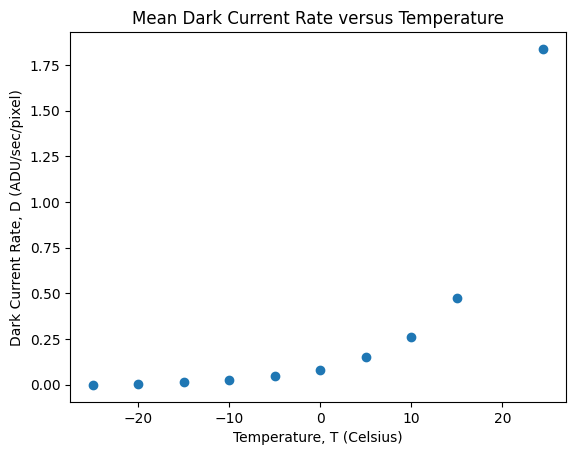

In [6]:
# plot mean dark current rate as a function of increasing temperature
plot_temps = [-25, -20, -15, -10, -5, 0, 5, 10, 15, 24.5]

plt.scatter(plot_temps, dark_current_mean)
plt.title('Mean Dark Current Rate versus Temperature')
plt.xlabel('Temperature, T (Celsius)')
plt.ylabel('Dark Current Rate, D (ADU/sec/pixel)')

Text(0, 0.5, 'Dark Current Rate, D (ADU/sec/pixel)')

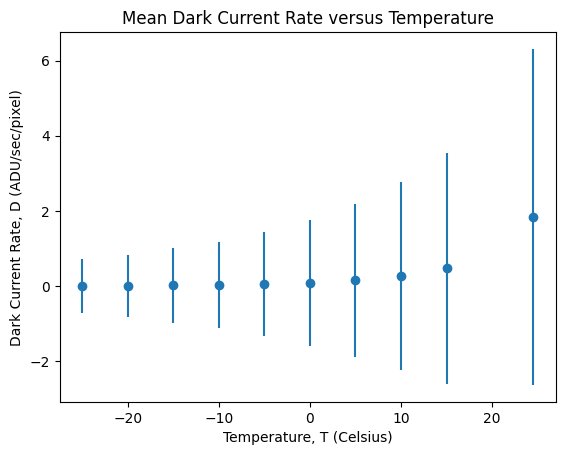

In [7]:
# adding error bars
plt.errorbar(plot_temps, dark_current_mean, dark_current_error, fmt='o')
plt.title('Mean Dark Current Rate versus Temperature')
plt.xlabel('Temperature, T (Celsius)')
plt.ylabel('Dark Current Rate, D (ADU/sec/pixel)')

Text(0, 0.5, 'Dark Current Rate, D (ADU/sec/pixel)')

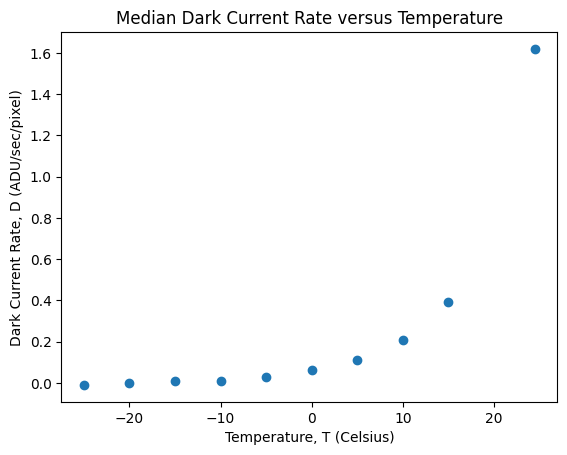

In [8]:
# reproduce plot for median
plt.scatter(plot_temps, dark_current_med)
plt.title('Median Dark Current Rate versus Temperature')
plt.xlabel('Temperature, T (Celsius)')
plt.ylabel('Dark Current Rate, D (ADU/sec/pixel)')

Text(0, 0.5, 'Dark Current Rate, D (ADU/sec/pixel)')

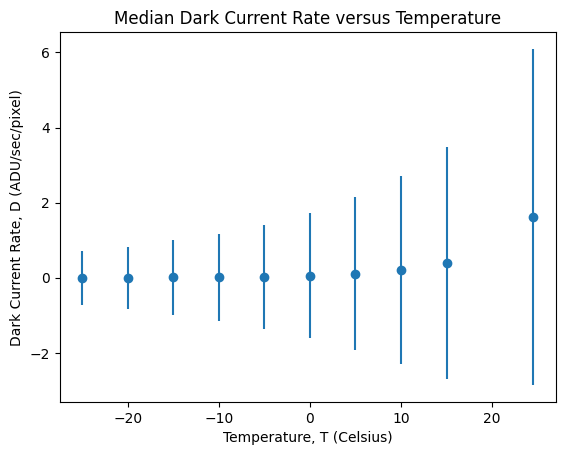

In [9]:
# error bars again
plt.errorbar(plot_temps, dark_current_med, dark_current_error, fmt='o')
plt.title('Median Dark Current Rate versus Temperature')
plt.xlabel('Temperature, T (Celsius)')
plt.ylabel('Dark Current Rate, D (ADU/sec/pixel)')

In [10]:
# params to fit curves to natural log of dark current rate versus negative inverse kelvin
temps_k = []
for i in range(len(temps)):
    temps_k.append(plot_temps[i] + 273.15)

inv_k = []
for i in range(len(temps_k)):
    inv_k.append(-1 / temps_k[i])

ln_mean = []
ln_mean_temps = []
ln_mean_error = []
for i in range(len(dark_current_mean)):
    if dark_current_mean[i] > 0:
        ln_mean_temps.append(inv_k[i])
        ln_mean.append(np.log(dark_current_mean[i]))
        ln_mean_error.append(dark_current_error[i] / dark_current_mean[i])     

ln_med = []
ln_med_temps = []
ln_med_error = []
for i in range(len(dark_current_med)):
    if dark_current_med[i] > 0:
        ln_med_temps.append(inv_k[i])
        ln_med.append(np.log(dark_current_med[i]))
        ln_med_error.append(dark_current_error[i] / dark_current_med[i])

# define function for ordinary least squares regression, y = mx + b form
def linear_function(x, m, b):
    return m * x + b

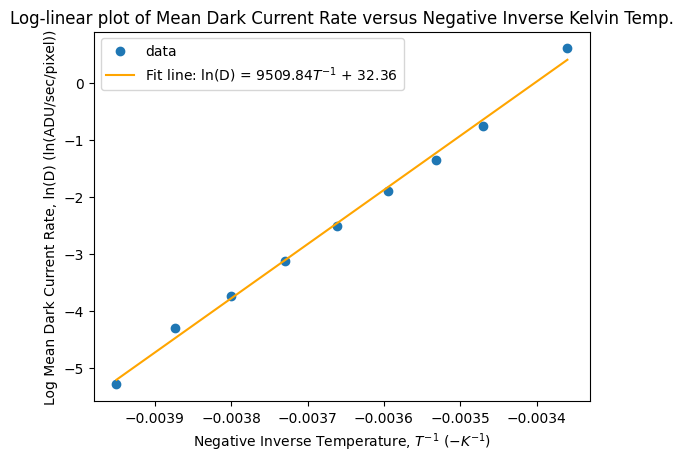

In [11]:
# fit curve, extract beta coefficients for ordinary least squares regression for mean
popt, pcov = curve_fit(linear_function, ln_mean_temps, ln_mean)
m, b = popt

# plot scatter plot
plt.scatter(ln_mean_temps, ln_mean, label='data')

# plot OLS fit line
x_regression = np.linspace(min(ln_mean_temps), max(ln_mean_temps), 100)
y_regression = linear_function(x_regression, m, b)

line_label = 'Fit line: ln(D) = ' + str(round(m, 2)) + '$T^{-1}$ + ' + str(round(b, 2))
plt.plot(x_regression, y_regression, color='orange', label=line_label)
plt.title('Log-linear plot of Mean Dark Current Rate versus Negative Inverse Kelvin Temp.')
plt.xlabel('Negative Inverse Temperature, $T^{-1}$ ($-K^{-1}$)')
plt.ylabel('Log Mean Dark Current Rate, ln(D) (ln(ADU/sec/pixel))')

plt.legend()

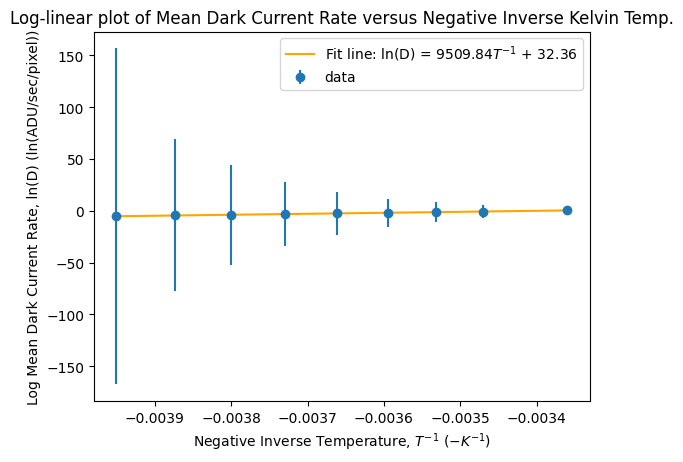

In [12]:
plt.errorbar(ln_mean_temps, ln_mean, ln_mean_error, label='data', fmt='o')

plt.plot(x_regression, y_regression, color='orange', label=line_label)
plt.title('Log-linear plot of Mean Dark Current Rate versus Negative Inverse Kelvin Temp.')
plt.xlabel('Negative Inverse Temperature, $T^{-1}$ ($-K^{-1}$)')
plt.ylabel('Log Mean Dark Current Rate, ln(D) (ln(ADU/sec/pixel))')

plt.legend()

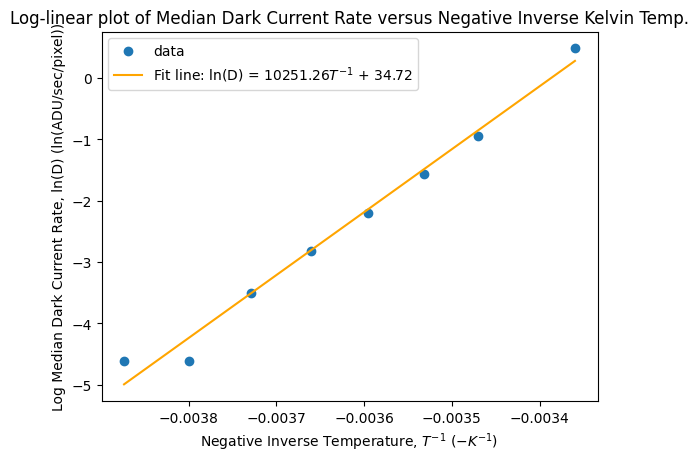

In [13]:
# fit curve, extract beta coefficients for ordinary least squares regression for median
popt, pcov = curve_fit(linear_function, ln_med_temps, ln_med)
m, b = popt

# plot scatter plot
plt.scatter(ln_med_temps, ln_med, label='data')

# plot OLS fit line
x_regression = np.linspace(min(ln_med_temps), max(ln_med_temps), 100)
y_regression = linear_function(x_regression, m, b)

line_label = 'Fit line: ln(D) = ' + str(round(m, 2)) + '$T^{-1}$ + ' + str(round(b, 2))
plt.plot(x_regression, y_regression, color='orange', label=line_label)
plt.title('Log-linear plot of Median Dark Current Rate versus Negative Inverse Kelvin Temp.')
plt.xlabel('Negative Inverse Temperature, $T^{-1}$ ($-K^{-1}$)')
plt.ylabel('Log Median Dark Current Rate, ln(D) (ln(ADU/sec/pixel))')
plt.legend()

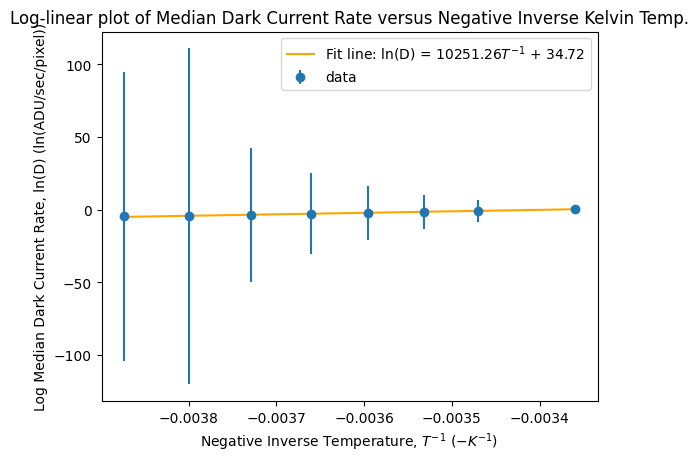

In [14]:
# plot scatter plot
plt.errorbar(ln_med_temps, ln_med, ln_med_error, label='data', fmt='o')

plt.plot(x_regression, y_regression, color='orange', label=line_label)
plt.title('Log-linear plot of Median Dark Current Rate versus Negative Inverse Kelvin Temp.')
plt.xlabel('Negative Inverse Temperature, $T^{-1}$ ($-K^{-1}$)')
plt.ylabel('Log Median Dark Current Rate, ln(D) (ln(ADU/sec/pixel))')
plt.legend()